# Ethereum LSTM Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
from helper_functions import *
from datetime import date, timedelta
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


#Importing the dataset and inspection
current_folder = os.path.abspath('')
ethereum_csv = os.path.join(current_folder, "data","ethereum_hourly.csv")
ethereum_df = pd.read_csv(ethereum_csv)

# Adding a difference high low as a possible feature to use
# in place of providing high and low seperately
ethereum_df['highLowDif'] = ethereum_df['highPriceUsd'] - ethereum_df['lowPriceUsd']

# converting datetime to datetime format (from stroing) for easierr filtering
ethereum_df['datetime'] = pd.to_datetime(ethereum_df['datetime'], errors='coerce')

# filtering dates to a hundred days from collection start
start_point = ethereum_df['datetime'][0]
end_point = start_point + timedelta(100)

filter_dates = ethereum_df['datetime'] >= pd.to_datetime(start_point)
timeperiod_df = ethereum_df[filter_dates]
filter_dates = timeperiod_df['datetime'] < pd.to_datetime(end_point)
timeperiod_df = timeperiod_df[filter_dates]

In [2]:
# double checking there are no nan values in the timeperiod
print(rows_with_nan_values(timeperiod_df))

[]


In [3]:
ethereum_df.iloc[0]

datetime                       2021-02-03 00:00:00+00:00
ethereum_count                                       508
ethereum_polarity                               0.172375
ethereum_subjectivity                           0.489083
ethereum_polarity_zeros                        0.0981143
ethereum_subjectivity_zeros                     0.321798
openPriceUsd                                     1514.77
closePriceUsd                                    1520.24
highPriceUsd                                     1530.61
lowPriceUsd                                      1514.77
volume                                       44437743410
marketcap                                   174085432619
highLowDif                                       15.8376
Name: 0, dtype: object

In [4]:
timeperiod_df = timeperiod_df.drop(columns=['datetime', 'ethereum_polarity_zeros', 'ethereum_subjectivity_zeros','ethereum_count', 'ethereum_polarity', 'ethereum_subjectivity','openPriceUsd',  'marketcap', 'highPriceUsd', 'lowPriceUsd'])

In [5]:
timeperiod_df.iloc[0]

closePriceUsd    1.520244e+03
volume           4.443774e+10
highLowDif       1.583755e+01
Name: 0, dtype: float64

In [6]:
# setting the training, validation, test split
# there are 2400 samples in the 100 day timeperiod
training_samples = int(len(timeperiod_df) * 0.7) # 1680
validation_samples = int(len(timeperiod_df) * 0.2) # 480
test_samples = int(len(timeperiod_df) * 0.1) # 240

# normalising the data
timeperiod_df = normalise_data(timeperiod_df, training_samples, validation_samples)

# returning factors used to normalise the data (in order to reverse)
mean, std = normalisation_values(timeperiod_df, training_samples, validation_samples)

# setting up sequence batches, how far back is looked and how far forward predictions are made
lookback = 120      # 120 / 24 = 5 days
step = 1            # 1hr step
delay = 24          # predictions 1 day in 'future'
batch_size = 128    

# creating the datasets of batches 
# (note due to) small size of test_dataset and te way the keras method to create timeseries datasets works, it is empty we will remake it
train_dataset, val_dataset, test_dataset = create_datasets(timeperiod_df, 'closePriceUsd', training_samples, validation_samples, lookback, step, delay, batch_size)

#clearing the test dataset
test_dataset = None

# getting the shape of the datasets to pass into model parameters
shape_1, shape_2 = get_dataset_shape(train_dataset)

final sample - training: 1680th, validation: 2160th, test: 2400th
Input shape: (128, 120, 3)
Target shape: (128, 1)


In [7]:
# extracting targets from the val_dataset to plot alongside predictions
y_val = np.concatenate([y for x, y in val_dataset], axis=0)

In [8]:
# This doesn't create a full dataset between the points
# find better method if time (like below)
combined_dataset = train_dataset.concatenate(val_dataset)

In [9]:
# setting up customised test_dataset
test_data = timeperiod_df[(training_samples+validation_samples) - lookback + delay:len(timeperiod_df) - delay - 1].to_numpy()

test_targets = timeperiod_df.iloc[(training_samples+validation_samples)+ delay + delay:, timeperiod_df.columns.get_loc("closePriceUsd")]
test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        test_data,
        None,
        sequence_length=lookback,
        sampling_rate=step,
        batch_size=batch_size,
    )

## LSTM models

Epoch 1/20
13/13 [==============================] - 11s 567ms/step - loss: 0.3567 - val_loss: 1.8906
Epoch 2/20
13/13 [==============================] - 7s 523ms/step - loss: 0.5162 - val_loss: 1.2215
Epoch 3/20
13/13 [==============================] - 6s 494ms/step - loss: 0.3931 - val_loss: 1.0612
Epoch 4/20
13/13 [==============================] - 7s 521ms/step - loss: 0.3313 - val_loss: 0.9498
Epoch 5/20
13/13 [==============================] - 7s 518ms/step - loss: 0.2862 - val_loss: 0.9007
Epoch 6/20
13/13 [==============================] - 6s 503ms/step - loss: 0.2353 - val_loss: 6.4751
Epoch 7/20
13/13 [==============================] - 7s 531ms/step - loss: 0.1860 - val_loss: 2.0932
Epoch 8/20
13/13 [==============================] - 7s 534ms/step - loss: 0.3430 - val_loss: 0.7774
Epoch 9/20
13/13 [==============================] - 7s 513ms/step - loss: 0.2368 - val_loss: 2.8567
Epoch 10/20
13/13 [==============================] - 7s 534ms/step - loss: 0.1797 - val_loss: 0.831

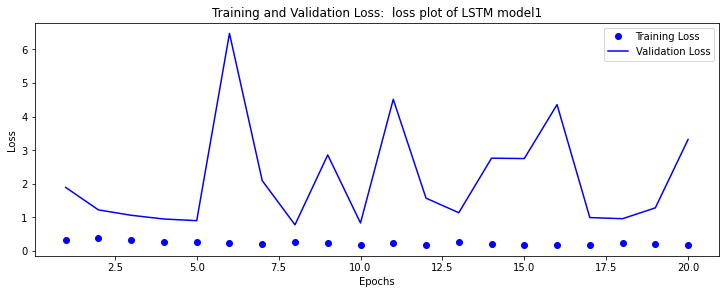

In [10]:
LSTM_model1 = models.Sequential()
LSTM_model1.add(layers.LSTM(100, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model1.add(layers.LSTM(100))


LSTM_model1.add(layers.Dense(1))

LSTM_model1.compile(optimizer=RMSprop(), loss='mse')
LSTM_model1_history = LSTM_model1.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model1_history, "loss plot of LSTM model1")

Epoch 1/20
13/13 [==============================] - 14s 666ms/step - loss: 0.3435 - val_loss: 1.5826
Epoch 2/20
13/13 [==============================] - 7s 523ms/step - loss: 0.4692 - val_loss: 1.1987
Epoch 3/20
13/13 [==============================] - 7s 529ms/step - loss: 0.3582 - val_loss: 1.2537
Epoch 4/20
13/13 [==============================] - 7s 505ms/step - loss: 0.4186 - val_loss: 0.9175
Epoch 5/20
13/13 [==============================] - 8s 595ms/step - loss: 0.3173 - val_loss: 0.9140
Epoch 6/20
13/13 [==============================] - 7s 538ms/step - loss: 0.2978 - val_loss: 0.8574
Epoch 7/20
13/13 [==============================] - 7s 540ms/step - loss: 0.2493 - val_loss: 0.8782
Epoch 8/20
13/13 [==============================] - 7s 545ms/step - loss: 0.2620 - val_loss: 1.1660
Epoch 9/20
13/13 [==============================] - 7s 503ms/step - loss: 0.3151 - val_loss: 0.7894
Epoch 10/20
13/13 [==============================] - 7s 586ms/step - loss: 0.2213 - val_loss: 0.762

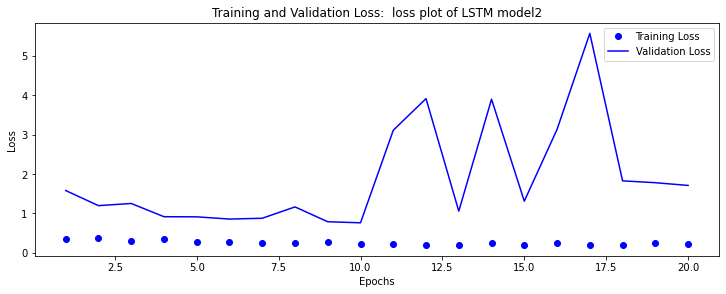

In [11]:
LSTM_model2 = models.Sequential()
LSTM_model2.add(layers.LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model2.add(layers.LSTM(100))


LSTM_model2.add(layers.Dense(1))

LSTM_model2.compile(optimizer=RMSprop(), loss='mse')
LSTM_model2_history = LSTM_model2.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model2_history, "loss plot of LSTM model2")

Epoch 1/20
13/13 [==============================] - 8s 416ms/step - loss: 0.3934 - val_loss: 2.6603
Epoch 2/20
13/13 [==============================] - 5s 368ms/step - loss: 0.4932 - val_loss: 2.1533
Epoch 3/20
13/13 [==============================] - 6s 455ms/step - loss: 0.3736 - val_loss: 1.8740
Epoch 4/20
13/13 [==============================] - 5s 417ms/step - loss: 0.3174 - val_loss: 1.6369
Epoch 5/20
13/13 [==============================] - 5s 363ms/step - loss: 0.2861 - val_loss: 1.4467
Epoch 6/20
13/13 [==============================] - 5s 376ms/step - loss: 0.2609 - val_loss: 1.3033
Epoch 7/20
13/13 [==============================] - 5s 420ms/step - loss: 0.2427 - val_loss: 1.1512
Epoch 8/20
13/13 [==============================] - 5s 382ms/step - loss: 0.2314 - val_loss: 1.0320
Epoch 9/20
13/13 [==============================] - 5s 406ms/step - loss: 0.2229 - val_loss: 0.9357
Epoch 10/20
13/13 [==============================] - 5s 373ms/step - loss: 0.2174 - val_loss: 4.9401

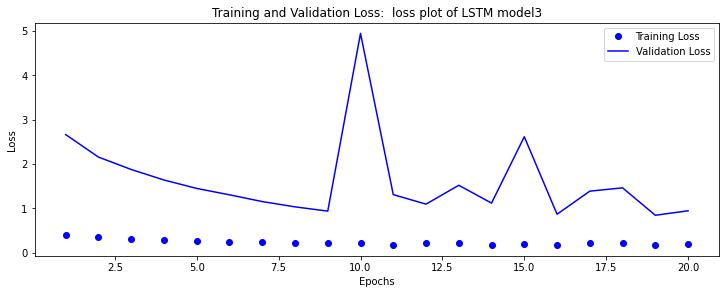

In [12]:
LSTM_model3 = models.Sequential()
LSTM_model3.add(layers.LSTM(100, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model3.add(layers.LSTM(50))


LSTM_model3.add(layers.Dense(1))

LSTM_model3.compile(optimizer=RMSprop(), loss='mse')
LSTM_model3_history = LSTM_model3.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model3_history, "loss plot of LSTM model3")

Epoch 1/20
13/13 [==============================] - 9s 425ms/step - loss: 0.3273 - val_loss: 2.9259
Epoch 2/20
13/13 [==============================] - 7s 535ms/step - loss: 0.5957 - val_loss: 2.3034
Epoch 3/20
13/13 [==============================] - 6s 509ms/step - loss: 0.4013 - val_loss: 2.0945
Epoch 4/20
13/13 [==============================] - 6s 477ms/step - loss: 0.3360 - val_loss: 1.8628
Epoch 5/20
13/13 [==============================] - 7s 585ms/step - loss: 0.2951 - val_loss: 1.9040
Epoch 6/20
13/13 [==============================] - 6s 440ms/step - loss: 0.2555 - val_loss: 2.0596
Epoch 7/20
13/13 [==============================] - 6s 481ms/step - loss: 0.2408 - val_loss: 1.4393
Epoch 8/20
13/13 [==============================] - 5s 416ms/step - loss: 0.3038 - val_loss: 1.5005
Epoch 9/20
13/13 [==============================] - 5s 414ms/step - loss: 0.2594 - val_loss: 1.4746
Epoch 10/20
13/13 [==============================] - 6s 464ms/step - loss: 0.2407 - val_loss: 4.2034

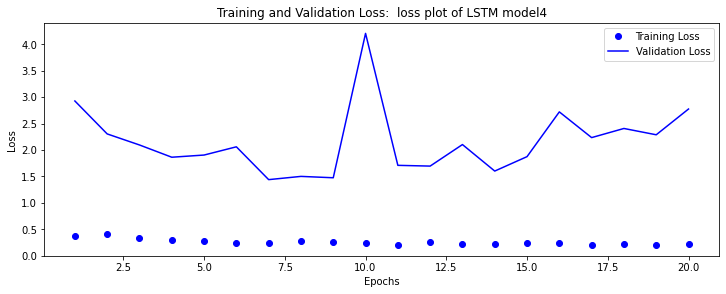

In [13]:
LSTM_model4 = models.Sequential()
LSTM_model4.add(layers.LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model4.add(layers.LSTM(50))


LSTM_model4.add(layers.Dense(1))

LSTM_model4.compile(optimizer=RMSprop(), loss='mse')
LSTM_model4_history = LSTM_model4.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model4_history, "loss plot of LSTM model4")

Epoch 1/30
13/13 [==============================] - 7s 356ms/step - loss: 0.4412 - val_loss: 7.1638
Epoch 2/30
13/13 [==============================] - 4s 331ms/step - loss: 0.4455 - val_loss: 5.1761
Epoch 3/30
13/13 [==============================] - 4s 311ms/step - loss: 0.4041 - val_loss: 4.6226
Epoch 4/30
13/13 [==============================] - 4s 339ms/step - loss: 0.3552 - val_loss: 4.1521
Epoch 5/30
13/13 [==============================] - 4s 306ms/step - loss: 0.3227 - val_loss: 3.7749
Epoch 6/30
13/13 [==============================] - 4s 311ms/step - loss: 0.2972 - val_loss: 3.4643
Epoch 7/30
13/13 [==============================] - 4s 314ms/step - loss: 0.2764 - val_loss: 3.2039
Epoch 8/30
13/13 [==============================] - 5s 374ms/step - loss: 0.2590 - val_loss: 2.9761
Epoch 9/30
13/13 [==============================] - 4s 296ms/step - loss: 0.2445 - val_loss: 2.8388
Epoch 10/30
13/13 [==============================] - 4s 304ms/step - loss: 0.2319 - val_loss: 2.6165

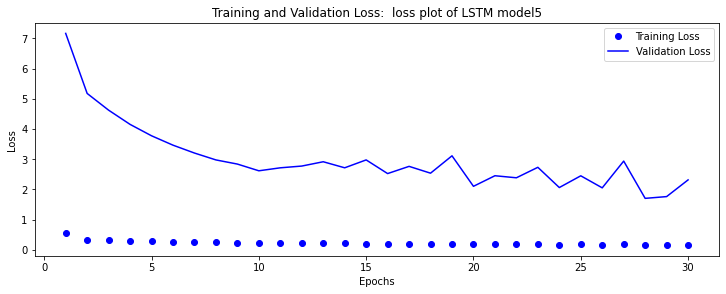

In [14]:
LSTM_model5 = models.Sequential()
LSTM_model5.add(layers.LSTM(50, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model5.add(layers.LSTM(50))


LSTM_model5.add(layers.Dense(1))

LSTM_model5.compile(optimizer=RMSprop(), loss='mse')
LSTM_model5_history = LSTM_model5.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model5_history, "loss plot of LSTM model5")

Epoch 1/20
13/13 [==============================] - 10s 398ms/step - loss: 0.3531 - val_loss: 5.2421
Epoch 2/20
13/13 [==============================] - 4s 351ms/step - loss: 0.4989 - val_loss: 4.5338
Epoch 3/20
13/13 [==============================] - 6s 384ms/step - loss: 0.3851 - val_loss: 4.0193
Epoch 4/20
13/13 [==============================] - 6s 450ms/step - loss: 0.3287 - val_loss: 3.4687
Epoch 5/20
13/13 [==============================] - 5s 362ms/step - loss: 0.3139 - val_loss: 3.2232
Epoch 6/20
13/13 [==============================] - 4s 299ms/step - loss: 0.2990 - val_loss: 3.0007
Epoch 7/20
13/13 [==============================] - 5s 398ms/step - loss: 0.2843 - val_loss: 2.9699
Epoch 8/20
13/13 [==============================] - 4s 321ms/step - loss: 0.2680 - val_loss: 2.7916
Epoch 9/20
13/13 [==============================] - 6s 459ms/step - loss: 0.2499 - val_loss: 2.7961
Epoch 10/20
13/13 [==============================] - 5s 354ms/step - loss: 0.2427 - val_loss: 2.897

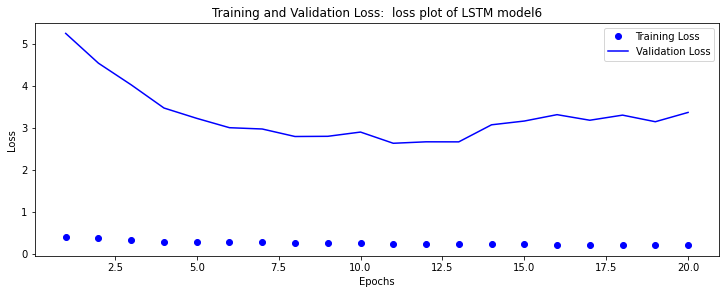

In [15]:
LSTM_model6 = models.Sequential()
LSTM_model6.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model6.add(layers.LSTM(50))


LSTM_model6.add(layers.Dense(1))

LSTM_model6.compile(optimizer=RMSprop(), loss='mse')
LSTM_model6_history = LSTM_model6.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model6_history, "loss plot of LSTM model6")

Epoch 1/30
13/13 [==============================] - 8s 370ms/step - loss: 0.4057 - val_loss: 7.5829
Epoch 2/30
13/13 [==============================] - 5s 376ms/step - loss: 0.3195 - val_loss: 6.6578
Epoch 3/30
13/13 [==============================] - 4s 285ms/step - loss: 0.3143 - val_loss: 6.2661
Epoch 4/30
13/13 [==============================] - 3s 231ms/step - loss: 0.2911 - val_loss: 5.9467
Epoch 5/30
13/13 [==============================] - 3s 248ms/step - loss: 0.2720 - val_loss: 5.6798
Epoch 6/30
13/13 [==============================] - 3s 270ms/step - loss: 0.2557 - val_loss: 5.4538
Epoch 7/30
13/13 [==============================] - 3s 235ms/step - loss: 0.2416 - val_loss: 5.2602
Epoch 8/30
13/13 [==============================] - 3s 234ms/step - loss: 0.2293 - val_loss: 5.0934
Epoch 9/30
13/13 [==============================] - 3s 247ms/step - loss: 0.2185 - val_loss: 4.9509
Epoch 10/30
13/13 [==============================] - 4s 347ms/step - loss: 0.2088 - val_loss: 4.8332

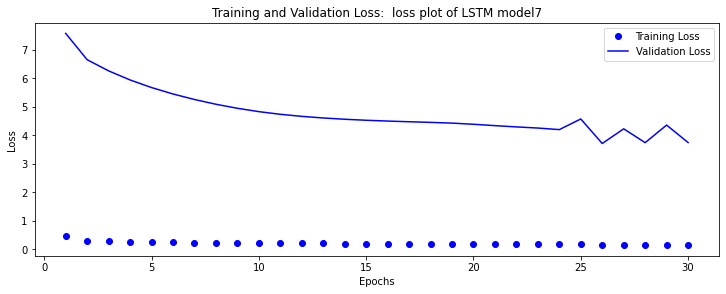

In [16]:
LSTM_model7 = models.Sequential()
LSTM_model7.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model7.add(layers.LSTM(32))


LSTM_model7.add(layers.Dense(1))

LSTM_model7.compile(optimizer=RMSprop(), loss='mse')
LSTM_model7_history = LSTM_model7.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model7_history, "loss plot of LSTM model7")

Epoch 1/20
13/13 [==============================] - 8s 365ms/step - loss: 0.4871 - val_loss: 11.4084
Epoch 2/20
13/13 [==============================] - 4s 329ms/step - loss: 0.2674 - val_loss: 8.0072
Epoch 3/20
13/13 [==============================] - 3s 259ms/step - loss: 0.3449 - val_loss: 7.4246
Epoch 4/20
13/13 [==============================] - 4s 304ms/step - loss: 0.3390 - val_loss: 7.1095
Epoch 5/20
13/13 [==============================] - 3s 249ms/step - loss: 0.3139 - val_loss: 6.9206
Epoch 6/20
13/13 [==============================] - 4s 268ms/step - loss: 0.3044 - val_loss: 6.8493
Epoch 7/20
13/13 [==============================] - 4s 323ms/step - loss: 0.2773 - val_loss: 6.5302
Epoch 8/20
13/13 [==============================] - 4s 316ms/step - loss: 0.2671 - val_loss: 6.4041
Epoch 9/20
13/13 [==============================] - 3s 248ms/step - loss: 0.2619 - val_loss: 6.3198
Epoch 10/20
13/13 [==============================] - 3s 264ms/step - loss: 0.2480 - val_loss: 6.138

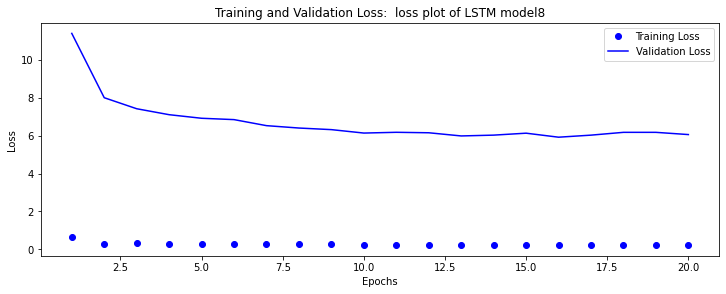

In [17]:
LSTM_model8 = models.Sequential()
LSTM_model8.add(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model8.add(layers.LSTM(32))


LSTM_model8.add(layers.Dense(1))

LSTM_model8.compile(optimizer=RMSprop(), loss='mse')
LSTM_model8_history = LSTM_model8.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model8_history, "loss plot of LSTM model8")

Epoch 1/30
13/13 [==============================] - 6s 253ms/step - loss: 0.6624 - val_loss: 17.5937
Epoch 2/30
13/13 [==============================] - 3s 210ms/step - loss: 0.3666 - val_loss: 13.9019
Epoch 3/30
13/13 [==============================] - 3s 207ms/step - loss: 0.3102 - val_loss: 12.0126
Epoch 4/30
13/13 [==============================] - 3s 203ms/step - loss: 0.3332 - val_loss: 11.0943
Epoch 5/30
13/13 [==============================] - 3s 214ms/step - loss: 0.3404 - val_loss: 10.6037
Epoch 6/30
13/13 [==============================] - 3s 218ms/step - loss: 0.3305 - val_loss: 10.3277
Epoch 7/30
13/13 [==============================] - 3s 229ms/step - loss: 0.3133 - val_loss: 10.1723
Epoch 8/30
13/13 [==============================] - 3s 230ms/step - loss: 0.2940 - val_loss: 10.0816
Epoch 9/30
13/13 [==============================] - 3s 218ms/step - loss: 0.2754 - val_loss: 10.0256
Epoch 10/30
13/13 [==============================] - 3s 205ms/step - loss: 0.2586 - val_los

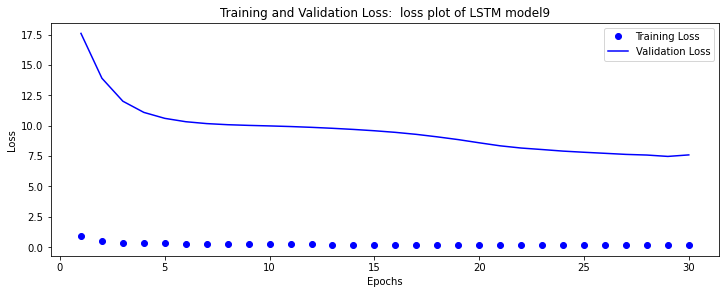

In [18]:
LSTM_model9 = models.Sequential()
LSTM_model9.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model9.add(layers.LSTM(16))


LSTM_model9.add(layers.Dense(1))

LSTM_model9.compile(optimizer=RMSprop(), loss='mse')
LSTM_model9_history = LSTM_model9.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model9_history, "loss plot of LSTM model9")

Epoch 1/20
13/13 [==============================] - 10s 405ms/step - loss: 0.5223 - val_loss: 13.2521
Epoch 2/20
13/13 [==============================] - 3s 229ms/step - loss: 0.3226 - val_loss: 10.9683
Epoch 3/20
13/13 [==============================] - 3s 253ms/step - loss: 0.3294 - val_loss: 9.8887
Epoch 4/20
13/13 [==============================] - 3s 244ms/step - loss: 0.3364 - val_loss: 9.3048
Epoch 5/20
13/13 [==============================] - 3s 237ms/step - loss: 0.3389 - val_loss: 8.9459
Epoch 6/20
13/13 [==============================] - 3s 263ms/step - loss: 0.3260 - val_loss: 8.6931
Epoch 7/20
13/13 [==============================] - 5s 326ms/step - loss: 0.3065 - val_loss: 8.4062
Epoch 8/20
13/13 [==============================] - 3s 256ms/step - loss: 0.3047 - val_loss: 8.1842
Epoch 9/20
13/13 [==============================] - 3s 240ms/step - loss: 0.2898 - val_loss: 8.0572
Epoch 10/20
13/13 [==============================] - 3s 241ms/step - loss: 0.2716 - val_loss: 7.8

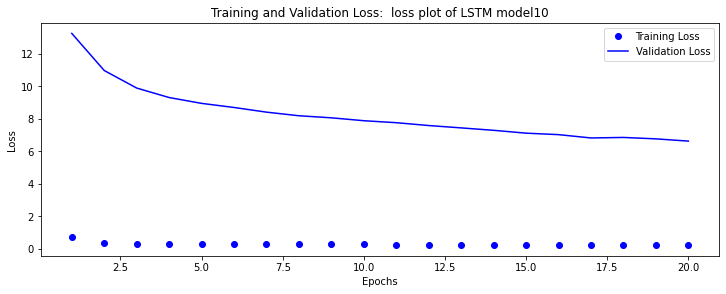

In [19]:
LSTM_model10 = models.Sequential()
LSTM_model10.add(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model10.add(layers.LSTM(16))


LSTM_model10.add(layers.Dense(1))

LSTM_model10.compile(optimizer=RMSprop(), loss='mse')
LSTM_model10_history = LSTM_model10.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model10_history, "loss plot of LSTM model10")

Epoch 1/50
13/13 [==============================] - 8s 355ms/step - loss: 0.9255 - val_loss: 23.7478
Epoch 2/50
13/13 [==============================] - 3s 213ms/step - loss: 0.8260 - val_loss: 23.2065
Epoch 3/50
13/13 [==============================] - 3s 216ms/step - loss: 0.7725 - val_loss: 22.6919
Epoch 4/50
13/13 [==============================] - 3s 230ms/step - loss: 0.7252 - val_loss: 22.0920
Epoch 5/50
13/13 [==============================] - 3s 228ms/step - loss: 0.6801 - val_loss: 21.4544
Epoch 6/50
13/13 [==============================] - 3s 271ms/step - loss: 0.6426 - val_loss: 20.8322
Epoch 7/50
13/13 [==============================] - 3s 226ms/step - loss: 0.6082 - val_loss: 20.2292
Epoch 8/50
13/13 [==============================] - 3s 222ms/step - loss: 0.5766 - val_loss: 19.6629
Epoch 9/50
13/13 [==============================] - 3s 221ms/step - loss: 0.5477 - val_loss: 19.1052
Epoch 10/50
13/13 [==============================] - 3s 220ms/step - loss: 0.5202 - val_los

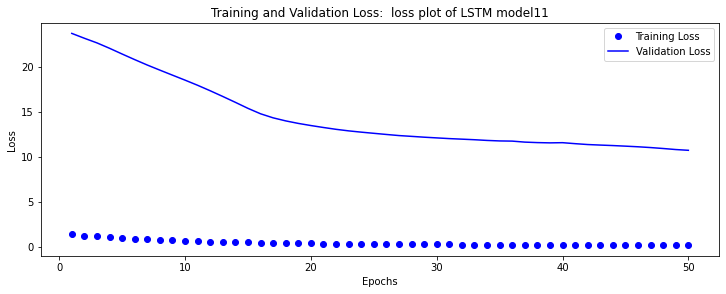

In [20]:
LSTM_model11 = models.Sequential()
LSTM_model11.add(layers.LSTM(10, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model11.add(layers.LSTM(5))


LSTM_model11.add(layers.Dense(1))

LSTM_model11.compile(optimizer=RMSprop(), loss='mse')
LSTM_model11_history = LSTM_model11.fit(train_dataset, epochs=50, validation_data=val_dataset)

plot_simple_loss(LSTM_model11_history, "loss plot of LSTM model11")

Epoch 1/20
13/13 [==============================] - 13s 596ms/step - loss: 0.5046 - val_loss: 3.1098
Epoch 2/20
13/13 [==============================] - 5s 410ms/step - loss: 0.5956 - val_loss: 2.7534
Epoch 3/20
13/13 [==============================] - 6s 481ms/step - loss: 0.5347 - val_loss: 2.7052
Epoch 4/20
13/13 [==============================] - 6s 459ms/step - loss: 0.4198 - val_loss: 2.2763
Epoch 5/20
13/13 [==============================] - 6s 427ms/step - loss: 0.4012 - val_loss: 2.1063
Epoch 6/20
13/13 [==============================] - 7s 549ms/step - loss: 0.3546 - val_loss: 1.9327
Epoch 7/20
13/13 [==============================] - 7s 519ms/step - loss: 0.3221 - val_loss: 1.7322
Epoch 8/20
13/13 [==============================] - 6s 501ms/step - loss: 0.3491 - val_loss: 1.7637
Epoch 9/20
13/13 [==============================] - 6s 506ms/step - loss: 0.3042 - val_loss: 1.6760
Epoch 10/20
13/13 [==============================] - 6s 479ms/step - loss: 0.2814 - val_loss: 1.706

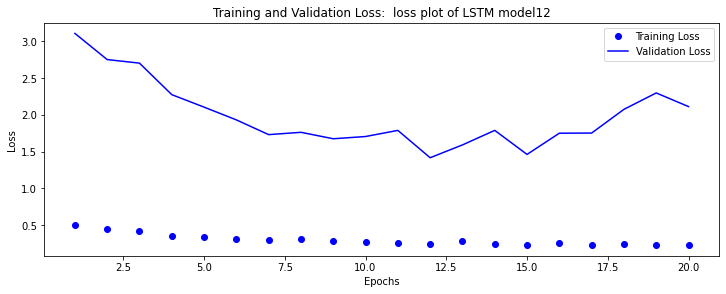

In [21]:
LSTM_model12 = models.Sequential()
LSTM_model12.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))
LSTM_model12.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
LSTM_model12.add(layers.LSTM(50))


LSTM_model12.add(layers.Dense(1))

LSTM_model12.compile(optimizer=RMSprop(), loss='mse')
LSTM_model12_history = LSTM_model12.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model12_history, "loss plot of LSTM model12")

Epoch 1/20
13/13 [==============================] - 16s 701ms/step - loss: 0.5453 - val_loss: 3.6672
Epoch 2/20
13/13 [==============================] - 8s 587ms/step - loss: 0.6103 - val_loss: 3.0288
Epoch 3/20
13/13 [==============================] - 9s 749ms/step - loss: 0.6241 - val_loss: 2.9930
Epoch 4/20
13/13 [==============================] - 7s 570ms/step - loss: 0.4936 - val_loss: 2.5853
Epoch 5/20
13/13 [==============================] - 7s 542ms/step - loss: 0.4678 - val_loss: 2.3011
Epoch 6/20
13/13 [==============================] - 10s 758ms/step - loss: 0.4465 - val_loss: 2.2612
Epoch 7/20
13/13 [==============================] - 8s 597ms/step - loss: 0.4078 - val_loss: 2.1706
Epoch 8/20
13/13 [==============================] - 10s 797ms/step - loss: 0.3717 - val_loss: 2.1063
Epoch 9/20
13/13 [==============================] - 8s 623ms/step - loss: 0.3834 - val_loss: 2.4066
Epoch 10/20
13/13 [==============================] - 10s 760ms/step - loss: 0.3449 - val_loss: 2.

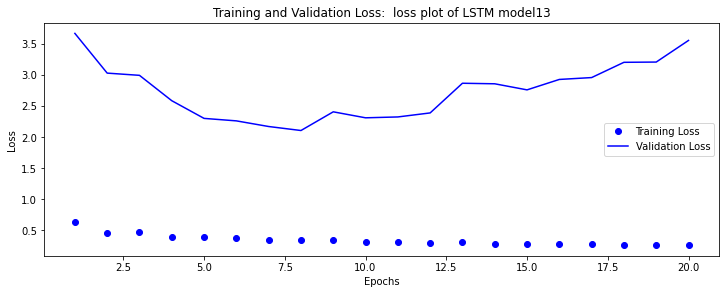

In [22]:
LSTM_model13 = models.Sequential()
LSTM_model13.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))
LSTM_model13.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
LSTM_model13.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
LSTM_model13.add(layers.LSTM(50))


LSTM_model13.add(layers.Dense(1))

LSTM_model13.compile(optimizer=RMSprop(), loss='mse')
LSTM_model13_history = LSTM_model13.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model13_history, "loss plot of LSTM model13")

Epoch 1/20
13/13 [==============================] - 7s 328ms/step - loss: 0.3678 - val_loss: 5.5028
Epoch 2/20
13/13 [==============================] - 4s 302ms/step - loss: 0.4043 - val_loss: 5.3475
Epoch 3/20
13/13 [==============================] - 4s 308ms/step - loss: 0.3290 - val_loss: 4.9150
Epoch 4/20
13/13 [==============================] - 4s 296ms/step - loss: 0.3009 - val_loss: 4.5395
Epoch 5/20
13/13 [==============================] - 4s 326ms/step - loss: 0.2802 - val_loss: 4.2048
Epoch 6/20
13/13 [==============================] - 4s 281ms/step - loss: 0.2629 - val_loss: 3.9065
Epoch 7/20
13/13 [==============================] - 4s 334ms/step - loss: 0.2487 - val_loss: 3.6457
Epoch 8/20
13/13 [==============================] - 4s 283ms/step - loss: 0.2365 - val_loss: 3.4210
Epoch 9/20
13/13 [==============================] - 3s 265ms/step - loss: 0.2263 - val_loss: 3.2461
Epoch 10/20
13/13 [==============================] - 4s 281ms/step - loss: 0.2172 - val_loss: 3.1285

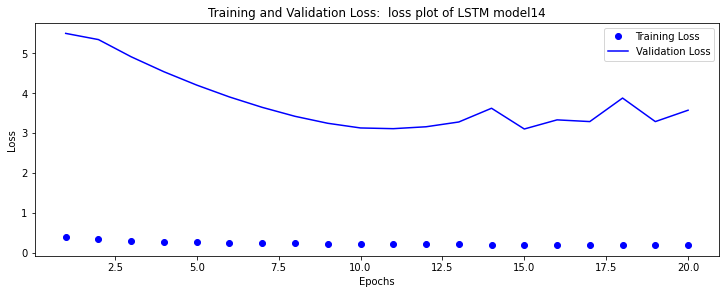

In [23]:
LSTM_model14 = models.Sequential()
LSTM_model14.add(layers.LSTM(64, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model14.add(layers.LSTM(32))


LSTM_model14.add(layers.Dense(1))

LSTM_model14.compile(optimizer=RMSprop(), loss='mse')
LSTM_model14_history = LSTM_model14.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model14_history, "loss plot of LSTM model14")

Epoch 1/40
13/13 [==============================] - 6s 240ms/step - loss: 0.6118 - val_loss: 16.0867
Epoch 2/40
13/13 [==============================] - 2s 182ms/step - loss: 0.4191 - val_loss: 14.2159
Epoch 3/40
13/13 [==============================] - 2s 186ms/step - loss: 0.3436 - val_loss: 12.4799
Epoch 4/40
13/13 [==============================] - 3s 198ms/step - loss: 0.3051 - val_loss: 10.9796
Epoch 5/40
13/13 [==============================] - 3s 243ms/step - loss: 0.2935 - val_loss: 9.8814
Epoch 6/40
13/13 [==============================] - 2s 189ms/step - loss: 0.2926 - val_loss: 9.1735
Epoch 7/40
13/13 [==============================] - 3s 195ms/step - loss: 0.2906 - val_loss: 8.7117
Epoch 8/40
13/13 [==============================] - 3s 195ms/step - loss: 0.2841 - val_loss: 8.3804
Epoch 9/40
13/13 [==============================] - 2s 184ms/step - loss: 0.2746 - val_loss: 8.1158
Epoch 10/40
13/13 [==============================] - 2s 187ms/step - loss: 0.2640 - val_loss: 7.

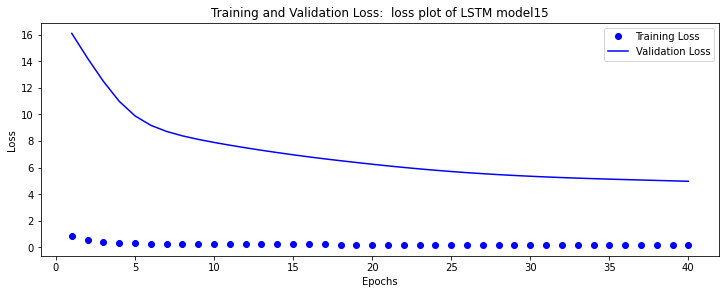

In [24]:
LSTM_model15 = models.Sequential()
LSTM_model15.add(layers.LSTM(16, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model15.add(layers.LSTM(16))


LSTM_model15.add(layers.Dense(1))

LSTM_model15.compile(optimizer=RMSprop(), loss='mse')
LSTM_model15_history = LSTM_model15.fit(train_dataset, epochs=40, validation_data=val_dataset)

plot_simple_loss(LSTM_model15_history, "loss plot of LSTM model15")

Epoch 1/20
13/13 [==============================] - 7s 365ms/step - loss: 0.4015 - val_loss: 3.1150
Epoch 2/20
13/13 [==============================] - 5s 369ms/step - loss: 0.4480 - val_loss: 2.7083
Epoch 3/20
13/13 [==============================] - 4s 315ms/step - loss: 0.3825 - val_loss: 2.4394
Epoch 4/20
13/13 [==============================] - 5s 369ms/step - loss: 0.3132 - val_loss: 2.1320
Epoch 5/20
13/13 [==============================] - 4s 331ms/step - loss: 0.2770 - val_loss: 1.9136
Epoch 6/20
13/13 [==============================] - 4s 327ms/step - loss: 0.2454 - val_loss: 1.9784
Epoch 7/20
13/13 [==============================] - 4s 330ms/step - loss: 0.2169 - val_loss: 3.7981
Epoch 8/20
13/13 [==============================] - 5s 416ms/step - loss: 0.1911 - val_loss: 1.7101
Epoch 9/20
13/13 [==============================] - 4s 340ms/step - loss: 0.2168 - val_loss: 5.9822
Epoch 10/20
13/13 [==============================] - 5s 387ms/step - loss: 0.1746 - val_loss: 1.4331

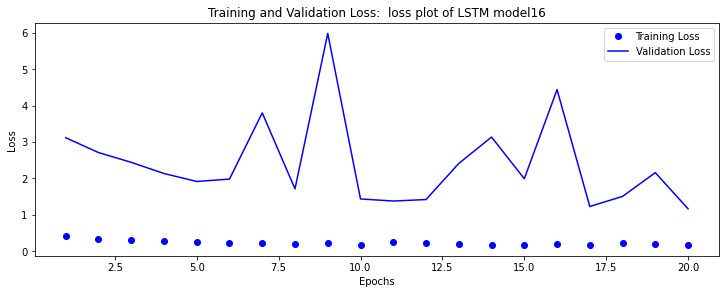

In [25]:
LSTM_model16 = models.Sequential()
LSTM_model16.add(layers.LSTM(64, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model16.add(layers.LSTM(64))


LSTM_model16.add(layers.Dense(1))

LSTM_model16.compile(optimizer=RMSprop(), loss='mse')
LSTM_model16_history = LSTM_model16.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model16_history, "loss plot of LSTM model16")

Epoch 1/30
13/13 [==============================] - 11s 474ms/step - loss: 0.4670 - val_loss: 7.6870
Epoch 2/30
13/13 [==============================] - 6s 501ms/step - loss: 0.6804 - val_loss: 7.4017
Epoch 3/30
13/13 [==============================] - 5s 373ms/step - loss: 0.5528 - val_loss: 6.8892
Epoch 4/30
13/13 [==============================] - 5s 411ms/step - loss: 0.4991 - val_loss: 6.4786
Epoch 5/30
13/13 [==============================] - 6s 433ms/step - loss: 0.4496 - val_loss: 6.0899
Epoch 6/30
13/13 [==============================] - 5s 380ms/step - loss: 0.4055 - val_loss: 5.7204
Epoch 7/30
13/13 [==============================] - 5s 375ms/step - loss: 0.3684 - val_loss: 5.3906
Epoch 8/30
13/13 [==============================] - 5s 380ms/step - loss: 0.3375 - val_loss: 5.1084
Epoch 9/30
13/13 [==============================] - 5s 367ms/step - loss: 0.3120 - val_loss: 4.8735
Epoch 10/30
13/13 [==============================] - 5s 366ms/step - loss: 0.2898 - val_loss: 4.727

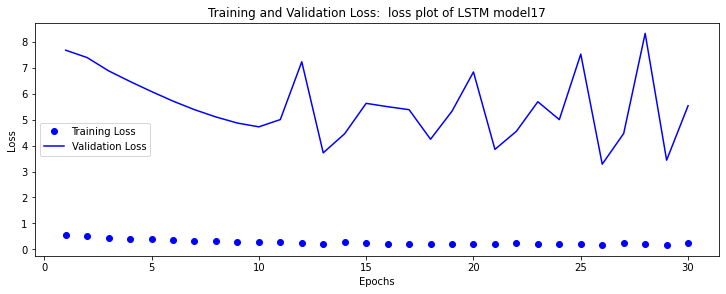

In [26]:
LSTM_model17 = models.Sequential()
LSTM_model17.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))
LSTM_model17.add(layers.LSTM(32, return_sequences=True))
LSTM_model17.add(layers.LSTM(32, return_sequences=True))
LSTM_model17.add(layers.LSTM(32))


LSTM_model17.add(layers.Dense(1))

LSTM_model17.compile(optimizer=RMSprop(), loss='mse')
LSTM_model17_history = LSTM_model17.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model17_history, "loss plot of LSTM model17")

Epoch 1/30
13/13 [==============================] - 10s 501ms/step - loss: 0.4184 - val_loss: 11.9240
Epoch 2/30
13/13 [==============================] - 4s 303ms/step - loss: 0.3333 - val_loss: 8.2374
Epoch 3/30
13/13 [==============================] - 4s 293ms/step - loss: 0.4008 - val_loss: 7.3290
Epoch 4/30
13/13 [==============================] - 4s 304ms/step - loss: 0.3917 - val_loss: 6.9368
Epoch 5/30
13/13 [==============================] - 4s 312ms/step - loss: 0.3531 - val_loss: 6.6054
Epoch 6/30
13/13 [==============================] - 4s 308ms/step - loss: 0.3207 - val_loss: 6.3015
Epoch 7/30
13/13 [==============================] - 4s 312ms/step - loss: 0.2946 - val_loss: 6.0234
Epoch 8/30
13/13 [==============================] - 4s 332ms/step - loss: 0.2725 - val_loss: 5.7905
Epoch 9/30
13/13 [==============================] - 4s 320ms/step - loss: 0.2526 - val_loss: 5.6238
Epoch 10/30
13/13 [==============================] - 6s 438ms/step - loss: 0.2343 - val_loss: 5.46

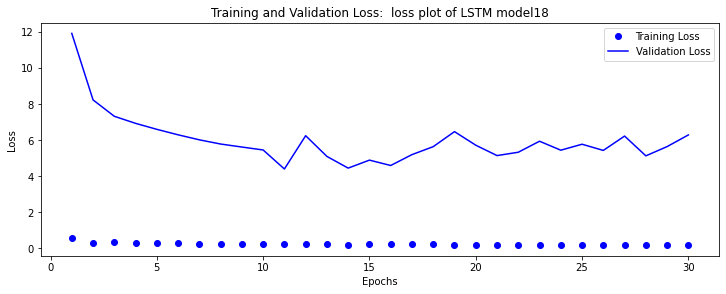

In [27]:
LSTM_model18 = models.Sequential()
LSTM_model18.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))
LSTM_model18.add(layers.LSTM(32, return_sequences=True))
LSTM_model18.add(layers.LSTM(32))


LSTM_model18.add(layers.Dense(1))

LSTM_model18.compile(optimizer=RMSprop(), loss='mse')
LSTM_model18_history = LSTM_model18.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model18_history, "loss plot of LSTM model18")

In [28]:
histories = [LSTM_model1_history, LSTM_model2_history, LSTM_model3_history, LSTM_model4_history, LSTM_model5_history, LSTM_model6_history, LSTM_model7_history, LSTM_model8_history, LSTM_model9_history, LSTM_model10_history, LSTM_model11_history, LSTM_model12_history, LSTM_model13_history, LSTM_model14_history, LSTM_model15_history, LSTM_model16_history, LSTM_model17_history, LSTM_model18_history]

for i in range(0, len(histories)):
    val_loss, epoch = lowest_val_loss_and_epoch(histories[i])
    print(f"Model {i+1}: min val loss: {val_loss}, epoch: {epoch}")

Model 1: min val loss: 0.7774455547332764, epoch: 8
Model 2: min val loss: 0.7622362971305847, epoch: 10
Model 3: min val loss: 0.8421884179115295, epoch: 19
Model 4: min val loss: 1.4393302202224731, epoch: 7
Model 5: min val loss: 1.7040679454803467, epoch: 28
Model 6: min val loss: 2.6306638717651367, epoch: 11
Model 7: min val loss: 3.7136685848236084, epoch: 26
Model 8: min val loss: 5.91967248916626, epoch: 16
Model 9: min val loss: 7.47237491607666, epoch: 29
Model 10: min val loss: 6.623816967010498, epoch: 20
Model 11: min val loss: 10.747947692871094, epoch: 50
Model 12: min val loss: 1.4177242517471313, epoch: 12
Model 13: min val loss: 2.106255054473877, epoch: 8
Model 14: min val loss: 3.1024580001831055, epoch: 15
Model 15: min val loss: 4.9653215408325195, epoch: 40
Model 16: min val loss: 1.1618400812149048, epoch: 20
Model 17: min val loss: 3.2852799892425537, epoch: 26
Model 18: min val loss: 4.406985759735107, epoch: 11
